In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
metaData1 = pd.read_csv("C:\\Users\\CJH\Desktop\\archive\\esea_meta_demos.part1.csv")
metaData2 = pd.read_csv("C:\\Users\\CJH\\Desktop\\archive\\esea_meta_demos.part2.csv")
metaData = pd.concat([metaData1, metaData2]) # combine the data which was seperate

In [6]:
metaData.head()

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550


Index(['Times Played', 'count'], dtype='object')


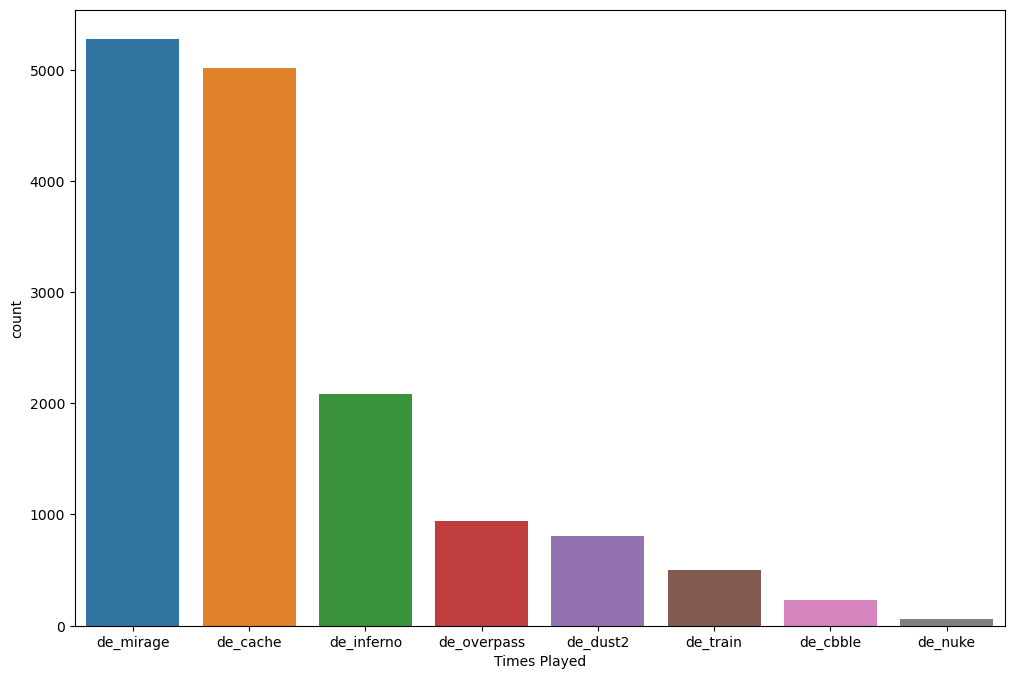

In [14]:
# picks out the relavent data and groups them by game and map
mapPrevalence = metaData.groupby(['file','map']).count().reset_index()[['file','map']]
# renames the column and counts the number of times a map is seen
mapPrevalence = mapPrevalence['map'].value_counts().reset_index().rename(columns = {'index':'Map', 'map':'Times Played'})
mapPrevalence.columns = ['Map', 'Times Played']

# plots the data
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(x='Map', y='Times Played', data = mapPrevalence)
print(mapPrevalence.columns)

In [15]:
gameRounds = metaData[['file','round']].groupby('file').max().rename(columns = {'round':'Number of Rounds'}).reset_index()

In [16]:
metaData[['file','round']].groupby('file').min()['round'].value_counts()

round
1    13198
2     1716
3        7
Name: count, dtype: int64

In [17]:
# it was going to be a little tedious to filter the start time of each round because of the above. So I just found an average
# start time and used that. The average game times are 2268 second which is small compared to the std of the start times.
startTime = metaData[['file','start_seconds']].groupby('file').min().mean()
startTimeStd = metaData[['file','start_seconds']].groupby('file').min().std()
print(startTime)
print(startTimeStd)

start_seconds    138.360112
dtype: float64
start_seconds    31.812854
dtype: float64


In [18]:
# finding the total game time
gameTime = metaData[['file','end_seconds']].groupby('file').max()
# renaming the columns and subtracting the average start time
gameTime = gameTime.rename(columns = {'end_seconds':'Game Time /min'})-startTime.iloc[0]
print(gameTime.mean())
# convert from seconds to minutes
gameTime /= 60

Game Time /min    2268.417493
dtype: float64


<Axes: xlabel='Game Time /min'>

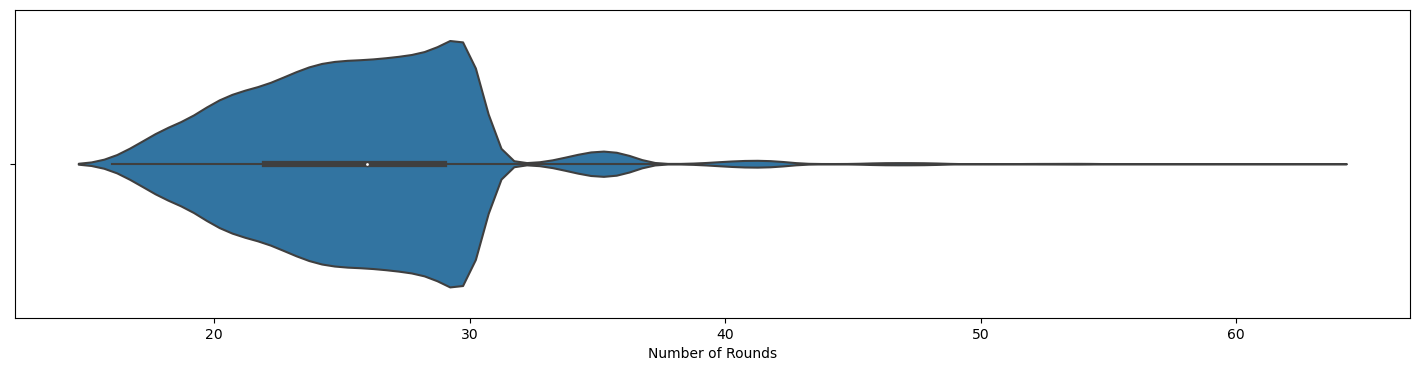

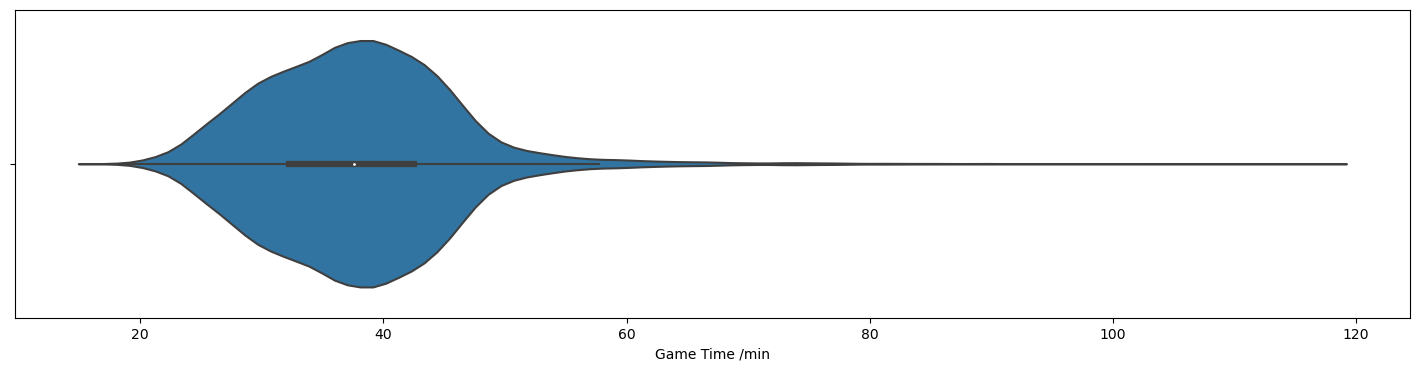

In [19]:
# plot the results for the number of rounds and minutes per game

fig, ax = plt.subplots(figsize=(18,4))
sns.violinplot(x = 'Number of Rounds', data = gameRounds, ax = ax)

fig2, ax2 = plt.subplots(figsize=(18,4))
sns.violinplot(x = 'Game Time /min', data = gameTime, ax = ax2)

In [20]:
# create a column with the round duration
metaData['Round Duration /s'] = metaData['end_seconds']-metaData['start_seconds']
# remove rounds that lasted more than 180 seconds as they must be erroneous
duration = metaData[metaData['Round Duration /s'] < 180]
#calculate the mean and std of the duration and present the data
durationMean = duration[['map','Round Duration /s']].groupby('map').mean()
durationStd = duration[['map','Round Duration /s']].groupby('map').std().rename(columns = {'Round Duration /s':'Sigma /s'})
pd.concat([durationMean, durationStd], axis = 1)

,Round Duration /s,Sigma /s
map,,
de_cache,86.100790,24.282304
de_cbble,86.031598,23.993863
de_dust2,83.452903,24.185220
de_inferno,91.436542,25.605594
de_mirage,84.807388,25.043647
de_nuke,83.238729,26.086363
de_overpass,90.802485,25.445677
de_train,82.106317,24.009712


<Axes: xlabel='Round Duration /s', ylabel='map'>

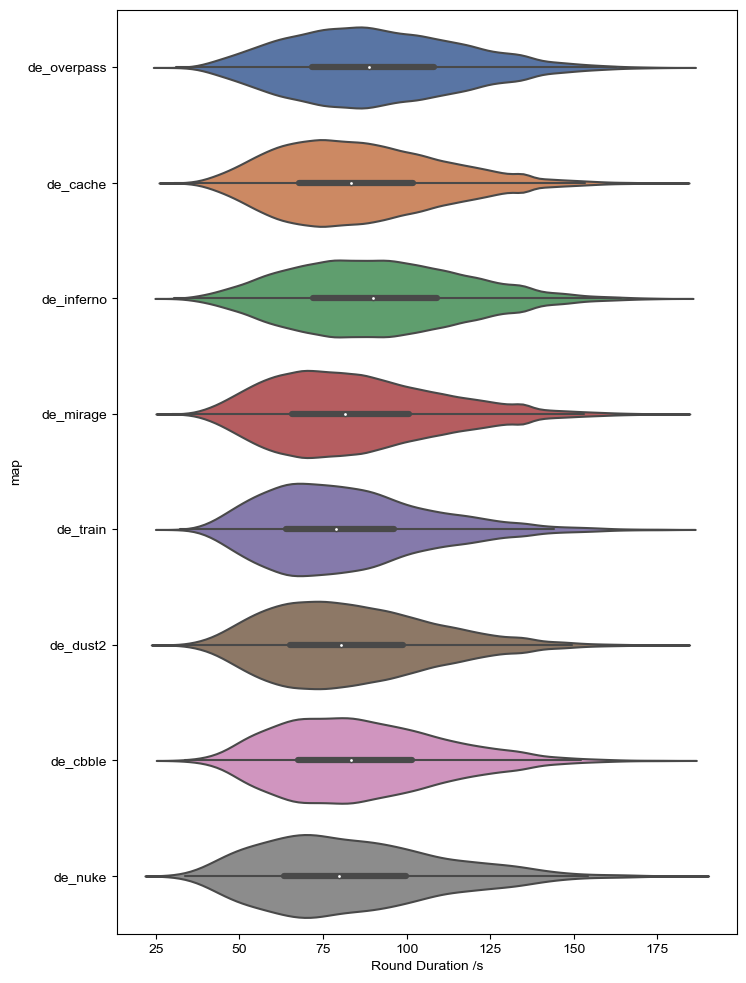

In [21]:
# plotting the data
fig, ax1 = plt.subplots(figsize = (8, 12))
sns.set(font_scale = 1.3)
sns.violinplot(y = 'map', x = 'Round Duration /s', data = duration)

In [26]:
# define an empty data frame to hold the data about who won the rounds
wins = pd.DataFrame()
# extract a dataframe with the relavent information
winner = metaData[['map','winner_side']]
for mapName in metaData['map'].unique(): # loop through the different maps that are played
    # calculate the number of times Ts and CTs one per map type
    tWins = winner[(winner['map']==mapName) & (winner['winner_side']=='Terrorist')].shape[0]
    ctWins = winner[(winner['map']==mapName) & (winner['winner_side']=='CounterTerrorist')].shape[0]
    # calculate it as a percentage and append all the data to the wins dataframe
    total = tWins + ctWins
    dataToAdd = pd.DataFrame({'Map':[mapName, mapName], 'Wins':[ctWins, tWins], 'Winning Side':['CT','T'], 
                              'Winning Percentage':[ctWins/total*100, tWins/total*100],
                               'Sidedness':[(ctWins-tWins)/total*100, (tWins-ctWins)/total*100]})
    wins = pd.concat([wins, dataToAdd], ignore_index=True)
wins

,Map,Wins,Winning Side,Winning Percentage,Sidedness
0,de_overpass,12136,CT,51.213234,2.426467
1,de_overpass,11561,T,48.786766,-2.426467
2,de_cache,60817,CT,47.504374,-4.991252
3,de_cache,67207,T,52.495626,4.991252
4,de_inferno,25034,CT,47.344731,-5.310538
5,de_inferno,27842,T,52.655269,5.310538
6,de_mirage,66373,CT,49.956722,-0.086557
7,de_mirage,66488,T,50.043278,0.086557
8,de_train,6711,CT,53.245002,6.490003
9,de_train,5893,T,46.754998,-6.490003


<Axes: xlabel='Map', ylabel='T-Sidedness'>

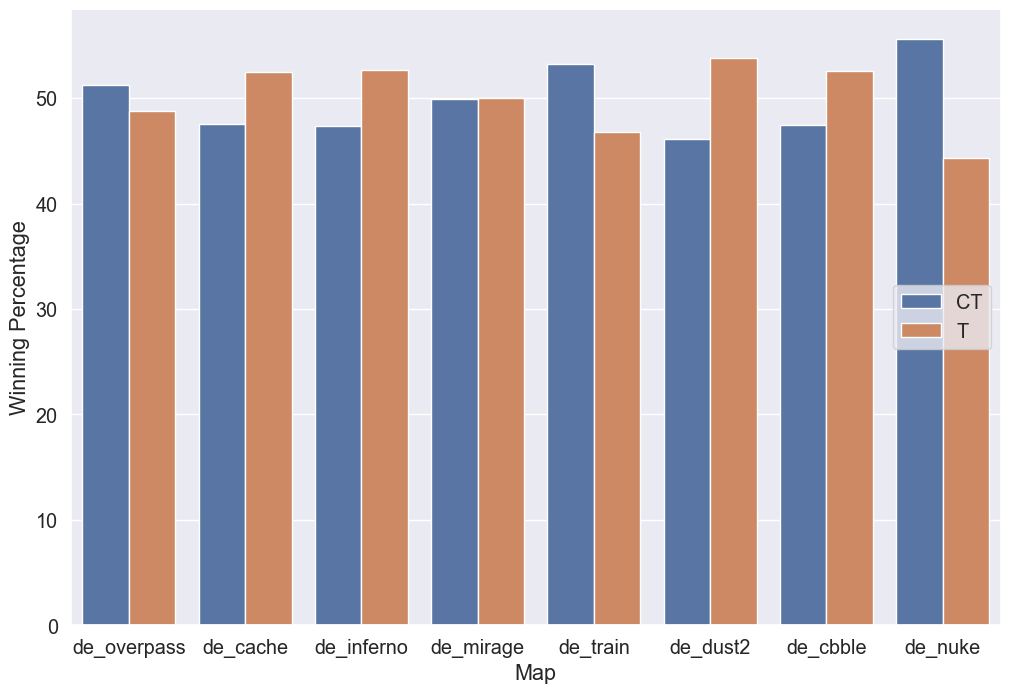

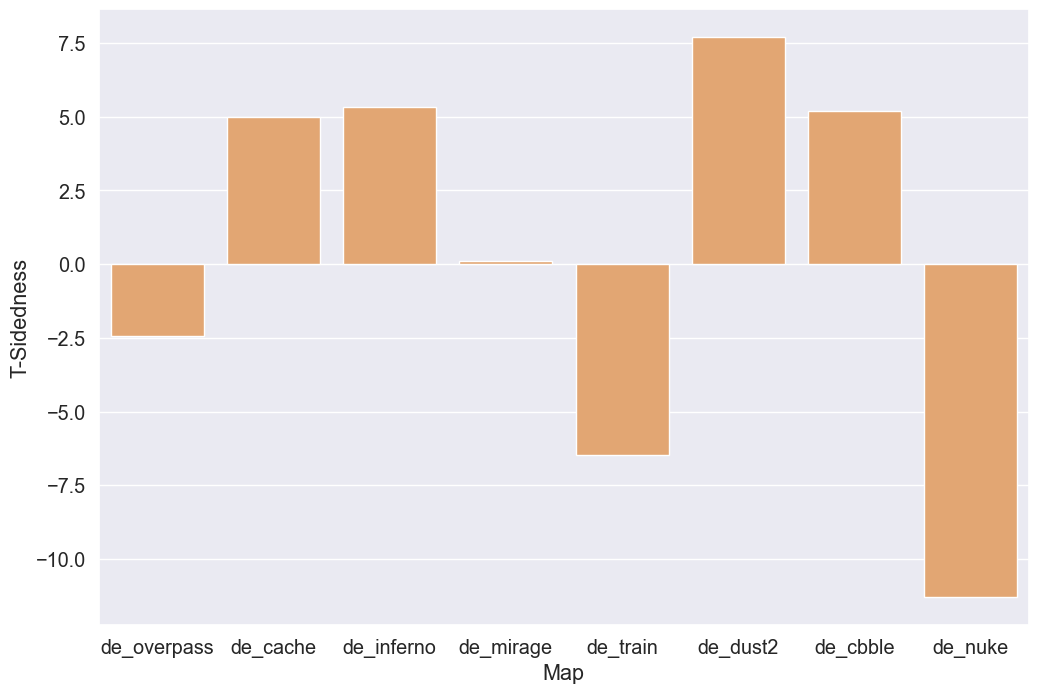

In [27]:

fig1, ax1 = plt.subplots(figsize=(12,8))
sns.set(font_scale = 1.3)
sns.barplot(x='Map',y='Winning Percentage',hue='Winning Side',data=wins, ax= ax1)
ax1.legend(loc = 7)

fig2, ax2 = plt.subplots(figsize=(12,8))
filteredWins = wins[wins['Winning Side'] == 'T'][['Map','Sidedness']].rename(columns={'Sidedness':'T-Sidedness'})
sns.barplot(x='Map', y = 'T-Sidedness', palette = ['sandybrown'], data = filteredWins, ax = ax2)

In [30]:
# extracting all the raw columns that don't need additional processing
dataProcessing1 = metaData[['round','ct_eq_val','t_eq_val']]

# converting the map data into a binary input for each map so it can be processed by the machine
maps = metaData['map'].unique() # order: overpass, cache, inferno, muirage, train, dust2, cobble, nuke
mapsBin = pd.DataFrame()
for mapp in maps:
    mapsBin[mapp] = metaData['map'].apply(lambda x: 1 if x == mapp else 0)
    
# creating the binary column with who won the previous round
# first create a series with a single value (to shift the series down)
s = pd.Series([0])
# creating a series with 1 if the it is not the first round and 0 if it is
isNotFirstRound = metaData['round'].apply(lambda x: 0 if x == 1 else 1).rename('isNotFirstRound').reset_index(drop=True)
# append the series from above, shifting the series down (now when the series are put together match up with the previous
#   match)
shiftedWinnerSide = pd.concat([s, metaData['winner_side']], ignore_index=True)
# create the two series with the binary output whether Ts or CTs won (cutting off the last row as it not meaningful)
tWinPrev = shiftedWinnerSide.apply(lambda x: 1 if x=='Terrorist' else 0).iloc[:-1]
ctWinPrev = shiftedWinnerSide.apply(lambda x: 1 if x=='CounterTerrorist' else 0).iloc[:-1]
# resetting the index for the next part
tWinPrev = tWinPrev.reset_index(drop=True)
ctWinPrev = ctWinPrev.reset_index(drop=True)
# multiply each series by the "isNotFirstRound" from above. This ensures that on pistol round nobody has won previously,
#    without this first rounds would have a previous winner and the machine may attempt to find a pattern in that
tWinPrev = (tWinPrev * isNotFirstRound).rename('tWinPrev')
ctWinPrev = (ctWinPrev * isNotFirstRound).rename('ctWinPrev')  # Fix the column name to 'ctWinPrev'
# combine the two series into a single dataframe
prevWinDF = pd.concat([tWinPrev,ctWinPrev], axis = 1)

# convert the round winner to a binary number. This is the data the machine will attempt to predict
dataToPredict = metaData['winner_side'].apply(lambda x: 1 if x=='Terrorist' else 0)

In [34]:
# Define the processedCols variable and assign it the necessary data
processedCols = [dataProcessing1, mapsBin, tWinPrev, ctWinPrev, dataToPredict]

# Reset the index of each DataFrame in processedCols
processedCols = [df.reset_index(drop=True) for df in processedCols]

# Now you can concatenate them into a single dataframe
processedData = pd.concat(processedCols, axis='columns', join='inner')

# Take a peek at the feature list
print('Feature list:')
print(processedData.columns)

Feature list:
Index(['round', 'ct_eq_val', 't_eq_val', 'de_overpass', 'de_cache',
       'de_inferno', 'de_mirage', 'de_train', 'de_dust2', 'de_cbble',
       'de_nuke', 'tWinPrev', 'ctWinPrev', 'winner_side'],
      dtype='object')


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [36]:
subset_size = 5000
X = processedData.drop('winner_side', axis = 1)[:subset_size]
y = processedData['winner_side'][:subset_size]
# split them into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# scale the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [37]:
# instantiate lists to hold the values
Ks = []
Kscores = []
# loop through different K values, testing each one, to find the optimal one
for K in range(15,100):
    kClassifier = KNeighborsClassifier(n_neighbors=K)
    kClassifier.fit(X_train, y_train)
    y_pred = kClassifier.predict(X_test)
    Kscores.append(f1_score(y_test, y_pred))
    Ks.append(K)

# extract and print the best K value
bestK = Ks[Kscores.index(max(Kscores))]
print(f'Optimal K-value: {bestK}')

kClassifier = KNeighborsClassifier(n_neighbors=bestK)
kClassifier.fit(X_train, y_train)
y_pred = kClassifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Optimal K-value: 67
[[413 224]
 [179 434]]
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       637
           1       0.66      0.71      0.68       613

    accuracy                           0.68      1250
   macro avg       0.68      0.68      0.68      1250
weighted avg       0.68      0.68      0.68      1250



In [38]:
depths = []
RFCscores = []
for depth in range(2, 16):
    forest = RandomForestClassifier(n_estimators=200, max_depth=depth, random_state=42)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    depths.append(depth)
    RFCscores.append(f1_score(y_test, y_pred))
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    
bestDepth = depths[RFCscores.index(max(RFCscores))]
print(f'Best depth setting: {bestDepth}')

forest = RandomForestClassifier(n_estimators=500, max_depth=bestDepth, random_state=42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best depth setting: 6
[[431 206]
 [206 407]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       637
           1       0.66      0.66      0.66       613

    accuracy                           0.67      1250
   macro avg       0.67      0.67      0.67      1250
weighted avg       0.67      0.67      0.67      1250

